# Quickstart: Amortized Posterior Estimation

In [1]:
import numpy as np
import tensorflow as tf

In [2]:
import bayesflow.diagnostics as diag
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import DeepSet, InvertibleNetwork
from bayesflow.simulation import GenerativeModel, Prior, Simulator
from bayesflow.trainers import Trainer

D:\Anaconda3\envs\TensorFlowDev\lib\site-packages\bayesflow\trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Introduction

Welcome to the very first tutorial on using BayesFlow for amortized posterior estimation! In this notebook, we will estimate the means of a multivariate Gaussian model and illustrate some features of the library along the way. Above, we have already imported the core entities we will need for this notebook. In brief:

* The module `simulations` contains high-level wrappers for gluing together priors, simulators, and context generators into a single `GenerateModel` object, which will generate all quantities of interest for a modeling scenario.
* The module `networks` contains the core neural architectures used for various tasks, e.g., a `DeepSet` for realizing normalizing flows (https://paperswithcode.com/method/normalizing-flows) or a `DeepSet` for learning permutation-invariant summary representations (embeddings).
* The module `amortizers` contains high-level wrappers which connect the various networks together and instruct them about their particular goals in the inference pipeline.
* The module `trainers` contains high-level wrappers for dictating the <em>training phase</em> of an amortized posterior. Typically, the standard `Trainer` will take care of most scenarios.

The nuts and bolts of using BayesFlow for Bayesian parameter estimation have already been described in the corresponding papers:
* <em>BayesFlow: Learning complex stochastic models with invertible neural networks</em> https://arxiv.org/abs/2003.06281
* <em>Detecting Model Misspecification in Amortized Bayesian Inference with Neural Networks</em> https://arxiv.org/abs/2112.08866

At a high level, our architecture consists of a summary network $h$ and an inference network $f$ which jointly amortize a generative model. 
The summary network transforms input data $\boldsymbol{x}$ of potentially variable size to a fixed-length representations.
The inference network generates random draws from an approximate posterior $q$ via a conditional invertible neural network (cINN). 
This process is illustrated in the figure below:

<img src=img/bayesflow_overview.png width=90%>

The left panel illustrates the <em>training phase</em>. During this phase, only the model (i.e., simulator and prior) is used to jointly train the summary and inference networks. The right panel illustrates the <em>inference phase</em>. During this phase, arbitrarily many actually observed data sets can be fed through the networks to obtain posteriors.
For instance, in one recent paper (https://www.nature.com/articles/s41562-021-01282-7), the authors applied pre-trained networks to more than one million observed data sets! Now let's get into some coding...

First and foremost, we set a local seed for reproducibility (best practice as of 2022).

In [3]:
RNG = np.random.default_rng(2022)

## Defining the Generative Model
From the perspective of the BayesFlow framework, a generative model is more than just a prior and a simulator. In addition, it consists of various <em>implicit</em> context assumptions, which we can make <em>explicit</em> at any time. Furthermore, we can also <em>amortize</em> over these context variables, thus making our real-world inference more flexible (i.e., applicable to more contexts). The figure below illustrates the skeleton of a generative model as conceptualized in the BayesFlow framework.

<img src=img/generative_model.png width=75%>

This conceptual model allows you to tackle very flexible model families with BayesFlow, as well as various other Bayesian tasks, such as prior sensitivity analysis or multiverse analysis.

The toy Gaussian model we will use for this tutorial takes a particularly simple form:

$$
\begin{align}
 \boldsymbol{\mu} &\sim \mathcal{N}_D(\boldsymbol{0}, \sigma_0\mathbb{I}) \\
 \boldsymbol{x}_n &\sim \mathcal{N}_D(\boldsymbol{\mu}, \sigma_1\mathbb{I})\quad\textrm{ for } n = 1,..,N,
\end{align}
$$
<br>
where $\mathcal{N}_D$ denotes a multivariate Gaussian (normal) density with $D$ dimensions, which we set at $D = 4$ for the current example. For simplicity, we will also set $\sigma_0 =1$ and $\sigma_1 = 1$. We will now implement this model using the latest numpy interface. 

### Prior
We first define a function generating single draws from the prior (as specified by our model formulation above), which we pass to the ``Prior`` wrapper.

In [4]:
def prior_fun(D=4):
    return RNG.normal(size=D)

In [5]:
prior = Prior(prior_fun=prior_fun)

That's it. The ``Prior`` object is now callable with a ``batch_size`` argument which dictates how many draws are generated from the prior. We can take a look at the outputs of the prior by doing:

In [6]:
prior(batch_size=10)

{'prior_draws': array([[ 2.67641529, -0.84279441,  2.07818003, -1.52765993],
        [ 0.39617851, -0.09590611, -2.47541091, -0.36716256],
        [ 0.59226504, -2.9312485 , -1.44023358,  0.07888769],
        [ 0.5856408 ,  1.66771611, -1.14089297, -0.20990006],
        [ 0.49681204,  1.01997171, -0.88286937, -1.33132135],
        [ 2.02567893,  0.81655117,  0.46034347,  0.17473455],
        [-0.72613673, -0.88523628, -1.61728344, -0.86198073],
        [-0.86489883,  0.56664501, -1.12666878, -1.44500009],
        [ 0.24692666,  1.23418102,  0.00576552,  0.53346655],
        [-1.15443727, -0.29927867,  2.15587299,  0.1004425 ]]),
 'batchable_context': None,
 'non_batchable_context': None}

Wow! The prior generated some other stuff that we never specified and packed it into a Python ``dict``. That definitely needs some explanation. Remember our picture above? A prior can also accept context variables which modify its behavior, whenever this is desirable. We will see this when we illustrate how to perform <em>prior sensitivity</em> analysis.
We also see two types of context variables. These are worth mentioning as well.
 The interface distinguishes between two types of context: ``batchable_context`` and ``non_batchable_context``. This distinction is a purely technical, rather then a conceptual one:
* Batchable context variables differ for each simulation in each training batch of simulations;
* Non-batchable context variables stay the same for each simulation in a batch, but differ across simulated batches;

Examples for <strong>batchable</strong> context variables include experimental design variables, design matrices, etc.
Examples for <strong>non-batchable</strong> context variables include the number of observations in an experiment, positional encodings, time indices, etc. While the latter can also be considered batchable in principle, batching them would require non-Tensor (i.e., non-rectangular) data structures, which usually means inefficient computations. 

### Simulator
In this case, our simulator function is equally simple to our prior function. We will call it a likelihood function, in correspondence with standard Bayesian terminology, and pass it to the ``Simulator`` wrapper.

In [7]:
def likelihood_fun(params, n_obs=50):
    return RNG.normal(loc=params, size=(n_obs, params.shape[0]))

In [8]:
simulator = Simulator(simulator_fun=likelihood_fun)

Note, that we define our ``simulator_fun`` with two arguments. A positional argument which stands for a single random draw from the prior and a keyword argument ``n_obs`` which represents the number of observations $N$ we will generate from the likelihood for each draw from the prior. As some point, we want to vary $N$ during training, so that the architecture can generalize to different $N$ during inference.

### Generative Model
We will now connect the prior with the likelihood (simulator) via the ``GenerativeModel`` interface:

In [9]:
model = GenerativeModel(prior=prior, simulator=simulator)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 50, 4)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


The generative model will also provide an internal consistency check and report on the tensor shapes of the different quantities output by the model. We can also manually inspect its outputs for ``batch_size = 3`` (i.e., three simulations):

In [10]:
out = model(batch_size=3)

In [11]:
print(list(out.keys()))

['prior_non_batchable_context', 'prior_batchable_context', 'prior_draws', 'sim_non_batchable_context', 'sim_batchable_context', 'sim_data']


In [12]:
print("Shape of sim_data: ", out["sim_data"].shape)

Shape of sim_data:  (3, 50, 4)


The output of the ``GenerativeModel`` is also a Python ``dict`` with even more keys than before. You should probably have an intuition what these keys represent, namely, the different types of context variables (none in this case) for prior and simulator. With this simple set-up, we can now proceed to do some posterior estimation.

## Defining the Neural Approximator

### Summary Network

Since our likelihood generates data exchangeably, we need to respect the permutation invariance of the data. For that, we will use a ``DeepSet`` which does exactly that. This network will take (at least) 3D tensors of shape ``(batch_size, n_obs, D)`` and reduce them to 2D tensors of shape ``(batch_size, summary_dim)``, where ``summary_dim`` is a hyperparameter to be set by the user (you). Heuristically, this number should not be lower than the number of parameters in a model. Below, we create an invariant network with ``summary_dim = 10``:

In [33]:
summary_net = DeepSet(summary_dim=10)

Note, that the hyperparameter setting for the ``InvariantNetwork`` are all provided inside a single Python dictionary. It helps to inspect the outputs of the summary network manually and confirm its operation:

In [34]:
test_inp = model(batch_size=3)
summary_rep = summary_net(test_inp["sim_data"]).numpy()

print("Shape of simulated data sets: ", test_inp["sim_data"].shape)
print("Shape of summary vectors: ", summary_rep.shape)

Shape of simulated data sets:  (3, 50, 4)
Shape of summary vectors:  (3, 10)


It is these summary vectors that will enter as conditions for the inference network. Upon convergence of the simulation-based training, we can think of them as <em>learned summary statistics</em> or <em>data embeddings</em>.

### Inference Network
Next we define the main workhorse of our our framework for amortized posterior inference - the conditional invertible neural network (cINN). The only mandatory hyperparameter for the ``InvertibleNetwork`` is the number of parameters we aim to estimate, in our case ``num_params = 4``. However, we can change some more, for instance set the number of coupling layers ``num_coupling_layers = 3``, which will make training faster than using the default ``num_coupling_layers = 6``, but also reduce the expressiveness (performance) of our network. Naturally, we don't need a lot of expressiveness for our trivial Gaussian model, so we can proceed with ``num_coupling_layers = 2``. Note, that we also remove the `L2` regularization from the networks, as we need this only for offline learning with pre-simulated data.

The invertible inference network has the following further hyperparameters:

* `num_params` (mandatory) - the number of model parameters (eq. the dimensionality of the latent space).
* `num_coupling_layers` - the number of invertible layers. The more layers, the more powerful the network, but the slower and possibly less stable the training. Typically $6 - 8$ coupling layers should be sufficient.
* `coupling_settings` - the settings for the internal coupling layers. Typically, the defaults work well, but small regularization should be added for 
* `coupling_design` - Normally, you would not touch this, unless using a custom design.
* `soft_clamping` - The soft-clamping parameter. Just use the default value.
* `permutation` - Whether to use permutations before each coupling layer. Should be used by default.
* `use_act_norm` - Whether to apply activation normalization after each coupling layer (https://arxiv.org/abs/1807.03039). Works well in practice and stabilizes training. 
* `act_norm_init` - In some cases, you can perform data-dependend initialization of the `ActNorm` layers, as in https://arxiv.org/abs/1807.03039.
* `use_soft_flow` - Whether to use a SoftFlow architecture (https://arxiv.org/abs/2006.04604). Useful for degenerate distributions.
* `soft_flow_bounds` - The bounds for the varying standard deviation of SoftFlow's noise. Do not touch, unless you have good reasons to.

You can glean all the defaults in the `default_settings` module. For most applications, you only need to define the `n_params` and `n_coupling_layers` hyperparameters

In [35]:
inference_net = InvertibleNetwork(num_params=4, coupling_settings={"dense_args": dict(kernel_regularizer=None)})

Again, we can inspect the raw outputs of the cINN by feeding it the parameter draws and corresponding data summaries. This network is slightly more involved than the summary network, as it has two mandatory inputs: ``targets`` and ``condition``. It also has two outputs: ``z`` and ``log_det_J``, which represent the latent representation of the parameters and the log of the Jacobian determinant, respectively.

In [36]:
z, log_det_J = inference_net(test_inp["prior_draws"], summary_rep)

We can inspect the shapes of the outputs as well:

In [37]:
print("Shape of latent variables:", z.numpy().shape)
print("Shape of log det Jacobian:", log_det_J.numpy().shape)

Shape of latent variables: (3, 4)
Shape of log det Jacobian: (3,)


### Amortized Posterior
We can now connect the ``summary_net`` and the ``inference_net`` via the high-level wrapper ``AmortizedPosterior``. This wrapper knows how to compute its loss function, draw samples from the approximate posterior given new data and also compute normalized posterior densities.

In [38]:
amortizer = AmortizedPosterior(inference_net, summary_net)

## Defining the Trainer
The ``Trainer`` instance connects a generative model with an amortizer and enables various types of simulation-based training. Actually, it has only a single mandatory argument, ``amortizer``, which expect an ``Amortized*`` instance. However, in order to be able to perform on-the-fly simulation-based training (see below), we also need to provide the generative model. Note, that the generative model does not need to use our provided wrappers, but the keys of its dictionary output should adhere to BayesFlow's expectations. 

Note: If you want to automatically save the ``amortizer`` and related loss history, you can provide a ``checkpoint_path`` argument indicating the folder for storing the checkpoints.

In [39]:
trainer = Trainer(amortizer=amortizer, generative_model=model)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Actually, a ``Trainer`` instance does a little more than connect a generative model to an amortizer. It does so through the help of a ``configurator``. In our case the configurator was inferred from the type of amortizer provided, but for more involved models, you should define the configurator explicitly.

What does a configurator do? It takes the raw outputs of the generative models and turns them into something with which neural networks can work:

<img src=img/trainer_connection.png width=75%>

Let's see how this actually works by accessing the default (inferred) configurator from the ``Trainer`` instance.

In [40]:
# Simulate some data again
out = model(3)
print("Keys of simulated dict: ", list(out.keys()))

Keys of simulated dict:  ['prior_non_batchable_context', 'prior_batchable_context', 'prior_draws', 'sim_non_batchable_context', 'sim_batchable_context', 'sim_data']


In [41]:
conf_out = trainer.configurator(out)

In [42]:
print("Keys of configured dict: ", list(conf_out.keys()))

Keys of configured dict:  ['summary_conditions', 'direct_conditions', 'parameters']


The default configurator for posterior inference differentiates between three types of model outputs:
1. ``parameters`` - these are the quantities for which we want posteriors.
2. ``summary_conditions`` - these are the quantities that go through the summary network (typically the raw data).
3. ``direct_conditions`` -- these are concatenated with the outputs of the summary network and passed directly to the inference network.

In our case, ``summary_conditions`` simply correspond to the data, and ``parameters`` correspond to the prior draws, but you can imagine that more complex scenarios are possible. Let's confirm the former claims.

In [43]:
print(np.allclose(out["sim_data"], conf_out["summary_conditions"]))
print(np.allclose(out["prior_draws"], conf_out["parameters"]))

True
True


Here, we are not using direct equality, since the configurator converts `float64` numbers to `float32` so as to use GPU memory more efficiently.

## Training Phase
The following training modes are currently available:

* <strong>Online training</strong> - This training regime is optimal for fast generative models which can efficiently simulated data on-the-fly. In order for this training regime to be efficient, on-the-fly batch simulations should not take longer than 2-3 seconds. The networks never see the same simulations twice.

* <strong>Experience replay</strong> - This training regime is also good for fast generative models which can efficiently simulated data on-the-fly. It will use a memory replay buffer, as utilized in reinforcement learning, so the network will eventually "experience" some simulations multiple times.
        
* <strong>Round-based training</strong> - This training regime is optimal for slow, but still reasonably performant generative models. In order for this training regime to be efficient, on-the-fly batch simulations should not take longer than one 2-3 minutes.

* <strong>Offline training</strong> - This training regime is optimal for very slow, external simulators, which take several minutes for a single simulation. It assumes that all training data has been already simulated and stored on disk.

Usually, domain modelers have a pretty good understanding of how fast a simulation model runs. We can also quickly measure the time taken for a given number of simulations (``batch_size``) directly inside the notebook.

In [44]:
%%time
_ = model(32)

CPU times: total: 0 ns
Wall time: 2.99 ms


We are well below the recommended 2-3 seconds for online training, so that is what we will do. Online training has three mandatory parameters: `epochs`, `iterations_per_epoch`, and `batch_size`. Thus, the total number of simulations that will be performed by a single call (run) will be `epochs` $\times$ `iterations_per_epoch` $\times$  `batch_size`. Moreover, the networks will never experience the same simulation twice, since each batch will contain a new set of simulations.

### Online Training
Note how the average loss goes down, along with the learning rate (LR). The latter happens, because BayesFlow uses a cosine decay for the learning rate by default, unless a custom optimizer from `tensorflow.optimizers` is provided. Thus, the learning rate will decrease atuomatically from its default value of $0.0005$ to $0$ over the course of the training. We will also use $100$ simulations for computing validation error.

Depending on your hardware, this training should take between $30$ seconds and $6$ minutes. 

In [45]:
%%time
history = trainer.train_online(epochs=10, iterations_per_epoch=500, batch_size=32, validation_sims=100)

INFO:root:Generated 100 simulations for validation.


Training epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 1.807


Training epoch 2:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 0.440


Training epoch 3:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 0.142


Training epoch 4:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: -0.948


Training epoch 5:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: -1.366


Training epoch 6:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: -1.719


Training epoch 7:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: -1.852


Training epoch 8:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Loss: -1.875


Training epoch 9:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Loss: -1.943


Training epoch 10:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Loss: -1.982


CPU times: total: 6min 43s
Wall time: 6min 17s


### Inspecting the Loss

We can inspect the evolution of the loss via a utility function ``plot_losses``, for which we have imported the ``diagnostics`` module from ``BayesFlow``.

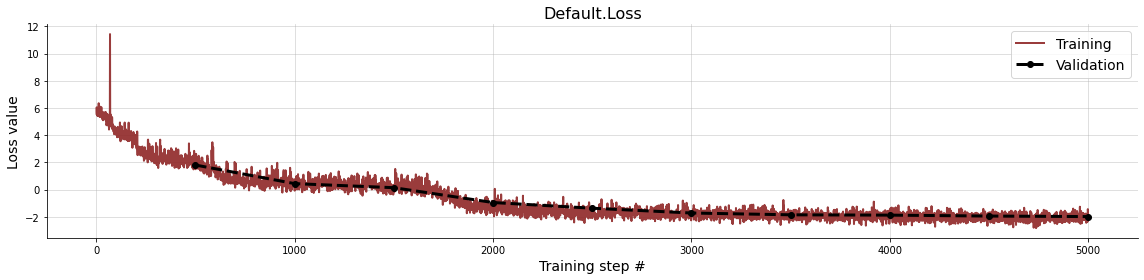

In [46]:
f = diag.plot_losses(history["train_losses"], history["val_losses"])

### Validating Consistency
Validating the consistency of our model-amortizer coupling is an important step which should be performed before any real data are presented to the networks. In other words, the model should work in the ''small world'', before going out in the world of real data. In addition to a smooth loss reduction curve, we can use three diagnostic utilities.

### Latent Space Plot
Since our training objective prescribes a unit Gaussian to the latent variable $\boldsymbol{z}$ (see: https://arxiv.org/abs/2003.06281), we expect that, upon good convergence, the latent space will exhibit the prescribed structure. We can quickly inspect this structure by calling the ``diagnose_latent2d`` method of the trainer.

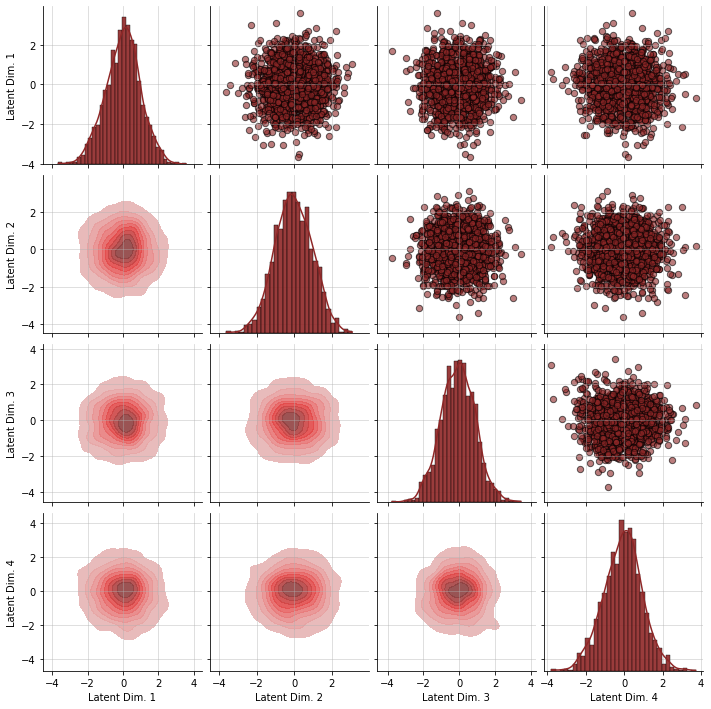

In [47]:
f = trainer.diagnose_latent2d()

Where did the `Trainer` get the data to create these plots? During training, the trainer secretly kept a portion of the model outputs into a `SimulationMemory` structure, which is then used by the diagnostic functions. Note, that these functions are also available as standalone versions in the `diagnostics` module, but require a novel validation set of simulations.

### Simulation-Based Calibration
By now a classic in Bayesian analysis. If you are not familiar with this procedure, you must read about it here: https://arxiv.org/abs/1804.06788

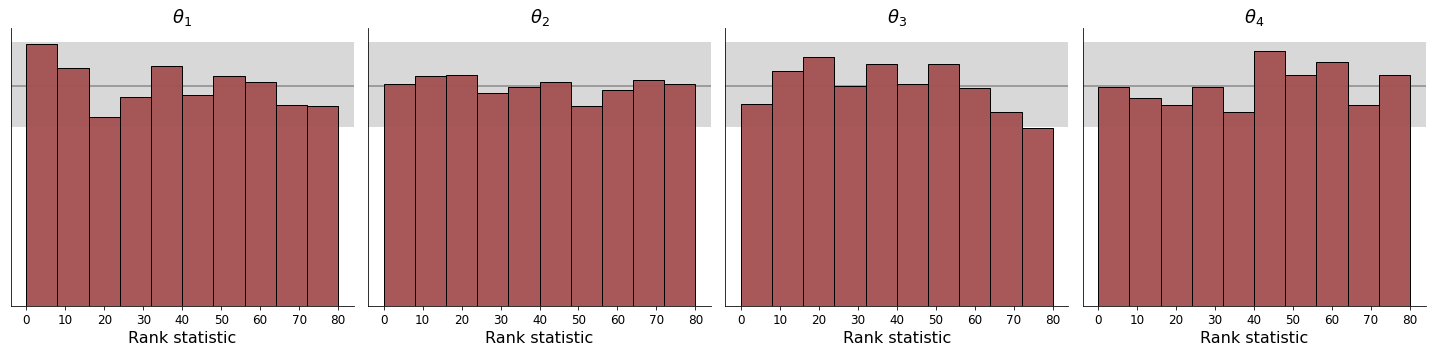

In [48]:
f = trainer.diagnose_sbc_histograms()

### Posterior z-score
A quick and dirty way to gain an understanding of how good point estimates and uncertainty estimates capture the "true" parameters, assuming the generative model is well-specified.

In [49]:
# Generate validation simulations (unseen by the network)
n_sim_validation = 100
val_data = trainer.configurator(model(n_sim_validation))

# Draw 500 posterior samples for each of the 100 simulated data sets
samples = amortizer.sample(val_data, n_samples=500)

Note the shapes of our resulting array: `(100, 500, 4)`. The resulting array holds the 500 posterior draws (axis 1) for each of the 100 data sets (axis 0). The final axis (axis 2) represents the number of target parameters.

In [50]:
print("Shape of posterior samples array:", samples.shape)

Shape of posterior samples array: (100, 500, 4)


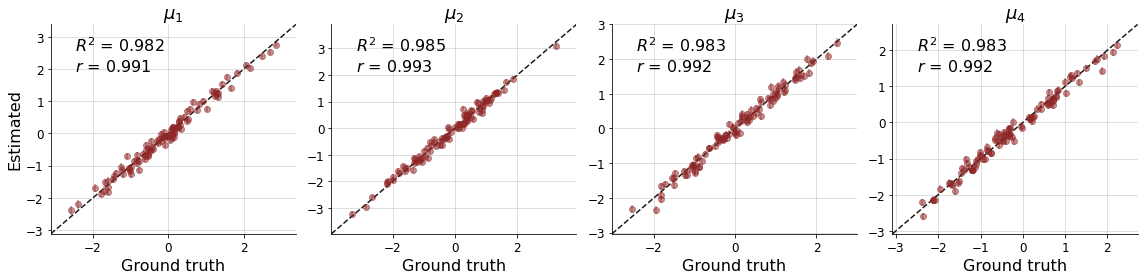

In [51]:
f = diag.plot_recovery(samples, val_data["parameters"], param_names=[r"$\mu_1$", r"$\mu_2$", r"$\mu_3$", r"$\mu_4$"])

## Inference Phase
Once the approximator has passed all consistency checks, we can now go ahead and apply it to real data! Since the data-generating parameters of real systems are per definition unobservable, we cannot use the same methods as below for ascertaining real-world validity of our inferences. Hence, as in any modeling scenario, we would need external validation and posterior predictive checks.